## Project: Forecast of fuel consumption by time series.

Description: A project on the Kaggle platform. https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
             Uses energy consumption data from the US regional organization PJM website.

Task: Build a time series model to predict energy consumption.
      In addition, this data is useful to identify spending trends by time of day, holidays, and beyond.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [1]:
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pmdarima as pm
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt

from prophet import Prophet
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline 
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

c:\Users\inetd\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

Data index is the date/hour, columns are for different regions within PJM.

Regions joined at different times, so not all have data for all dates. Regions also split (PJM_Load split to East and West)

In [5]:
#Show PJM Regions
from IPython.display import Image
Image(url= "http://slideplayer.com/4238181/14/images/4/PJM+Evolution.jpg")

In [2]:
# load data
# df=pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = pd.read_csv('data/PJME_hourly.csv')
df.drop_duplicates(subset = ['Datetime'], inplace=True)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


- Datetime  - timestemp
- PJME_MW   - Load Distribution in MW

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145362 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145362 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [4]:
print(f'count of nan: {df.PJME_MW.isna().sum()}\n'
      f'count of negative values: {len(df[df.PJME_MW <= 0])}\n'
      f'start data: {df.index[0]}\n'
      f'end data: {df.index[-1]}\n'
      f'count of observation: {df.shape[0]}'
)

count of nan: 0
count of negative values: 0
start data: 2002-12-31 01:00:00
end data: 2018-01-02 00:00:00
count of observation: 145362


In [ ]:
# show based statistic data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PJME_MW,145362.0,32080.505139,6463.874131,14544.0,27573.0,31421.0,35650.0,62009.0


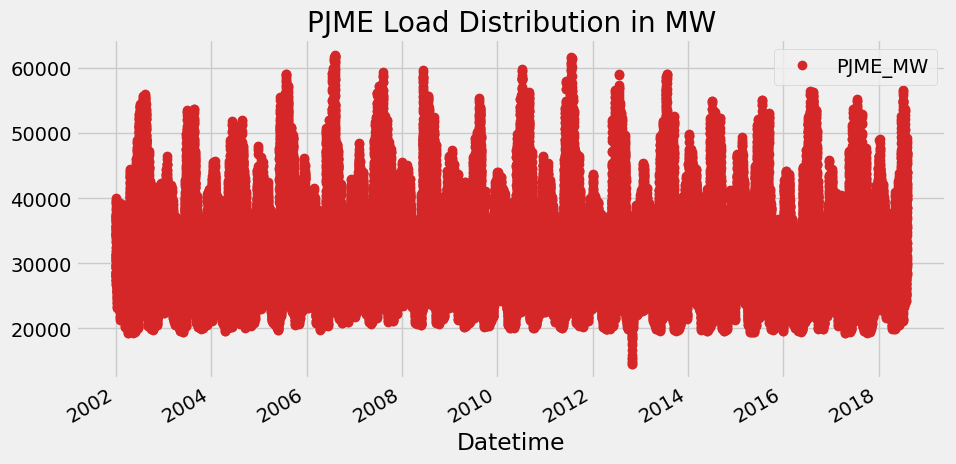

In [ ]:
# plot the graph of the load distribution by years
df.plot(style='o',
        figsize=(10, 5),
        color=color_pal[3],
        title='PJME Load Distribution in MW')
plt.show()

<AxesSubplot:title={'center':'Distribution of PJME Load'}, ylabel='Frequency'>

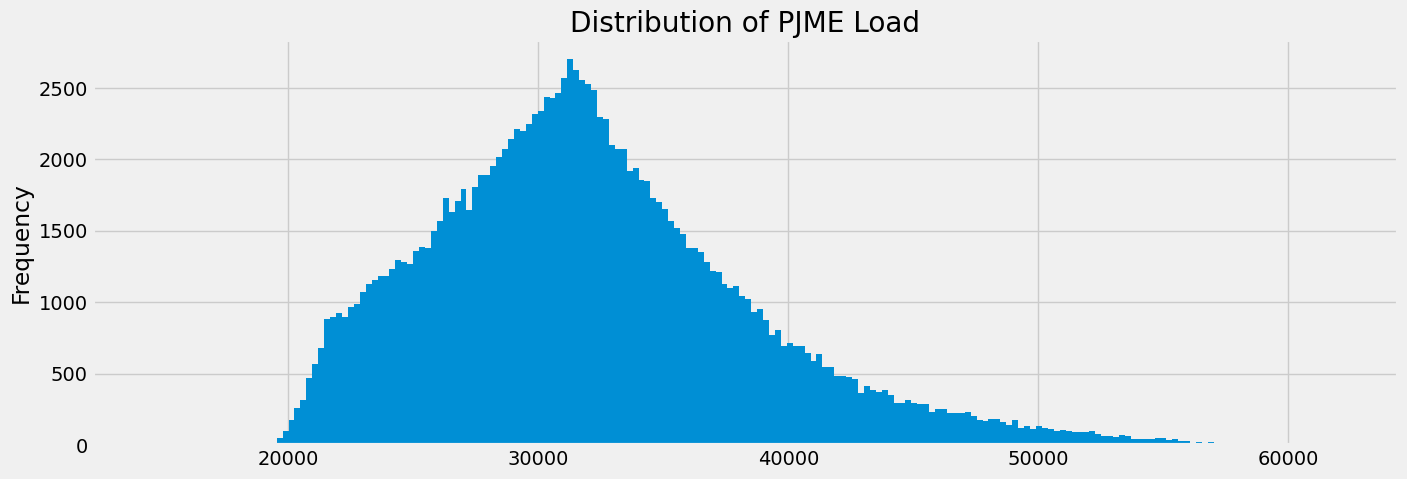

In [ ]:
# plot the graph of the load distribution by values
df['PJME_MW'].plot.hist(figsize=(15, 5), bins=200, title='Distribution of PJME Load')

Summer Demand vs Winter Demand
Note the dips mid-day in the winter months. Conversely in summer months the daily load is more bell shaped. This is due to high mid-day energy consumtion by air conditioning. In winter months people tend to use less energy mid-day.

<AxesSubplot:title={'center':'June 2017'}, xlabel='Datetime'>

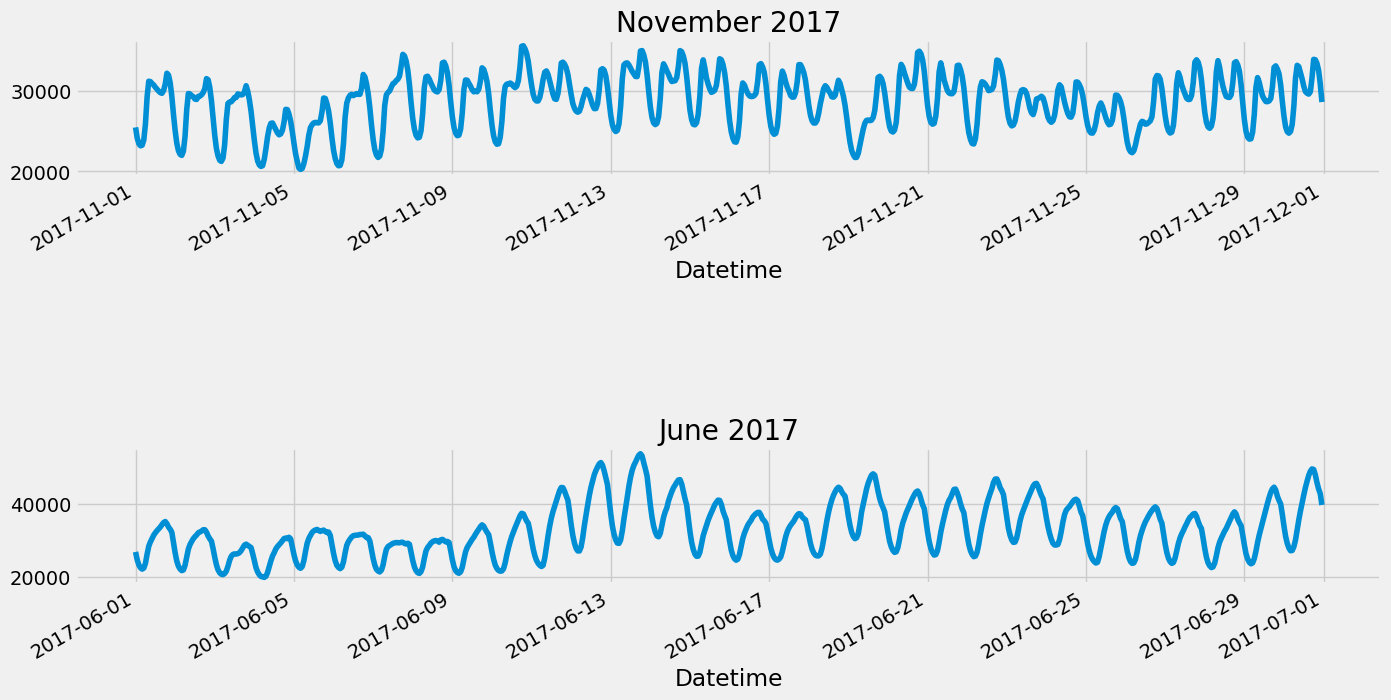

In [ ]:
# plot the graph of load distribution in winter and suumer season
fig, axs = plt.subplots(2,1, figsize = (15,8), gridspec_kw = {'hspace':2})
df['PJME_MW'].loc[(df['PJME_MW'].index >= '2017-11-01') &
               (df['PJME_MW'].index < '2017-12-01')] \
    .plot(ax = axs[0], title = 'November 2017')
df['PJME_MW'].loc[(df['PJME_MW'].index >= '2017-06-01') &
               (df['PJME_MW'].index < '2017-07-01')] \
    .plot(ax = axs[1], title = 'June 2017')

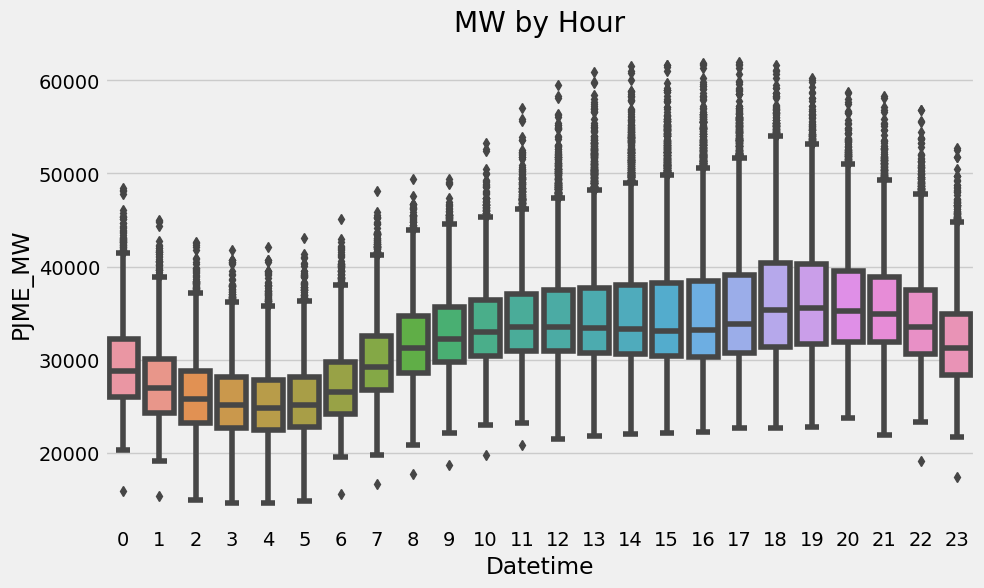

In [ ]:
# plot the boxplot of the load distribution by hours
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x=df.index.hour, y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

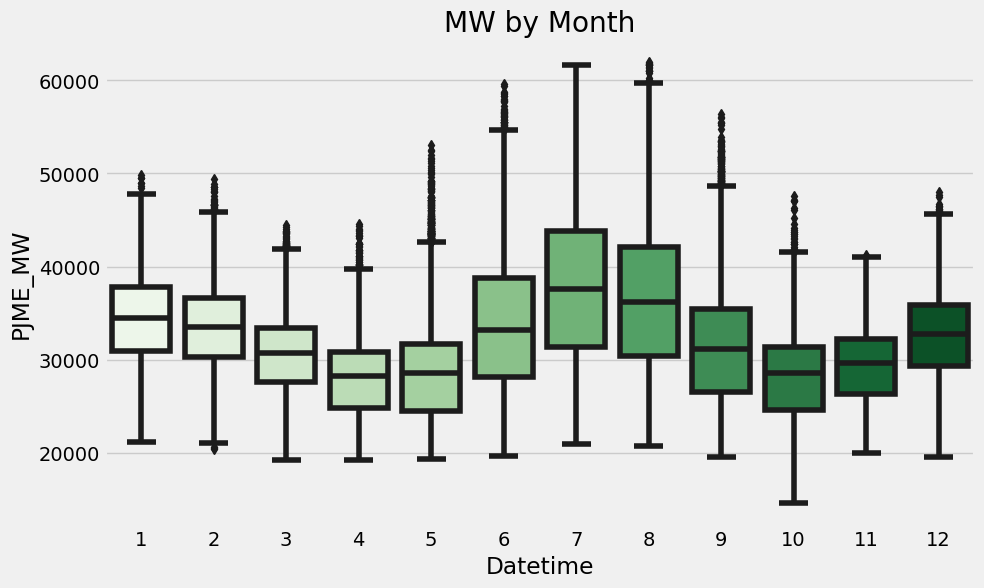

In [ ]:
# plot the boxplot of the load distribution by month
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x=df.index.month, y='PJME_MW', palette='Greens')
ax.set_title('MW by Month')
plt.show()

<AxesSubplot:title={'center':'PJM East - Daily Trends'}, xlabel='Datetime'>

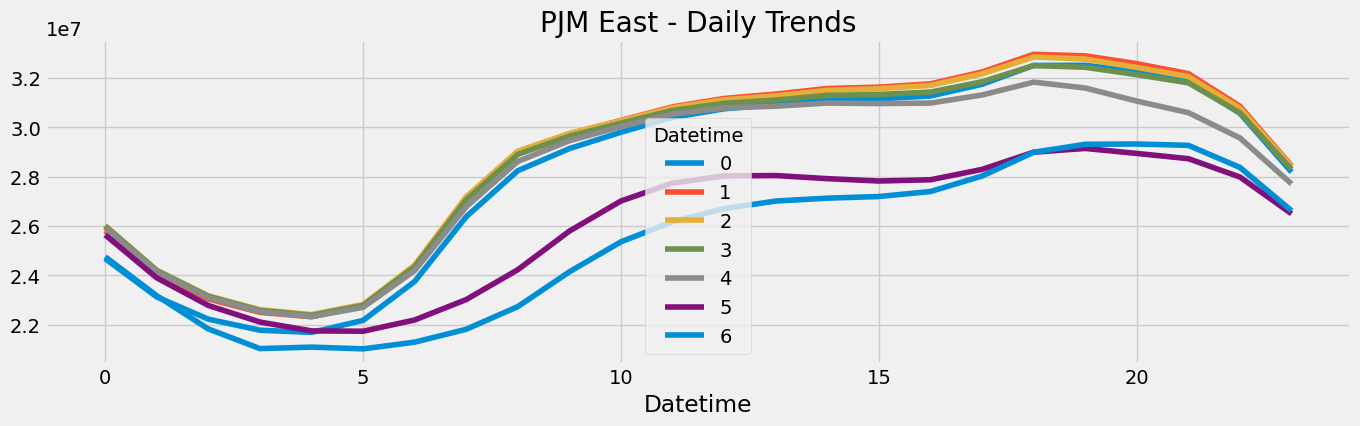

In [ ]:
# plot the daily trends of the load distribution by hours
df.pivot_table(index=df.index.hour, 
                     columns=df.index.dayofweek, 
                     values='PJME_MW',
                     aggfunc='sum').plot(figsize=(15,4),
                     title='PJM East - Daily Trends')

### Decomposition

Decomposition provide us to select the next component of the series:
- trend component
- seasonl component
- resid (noise)

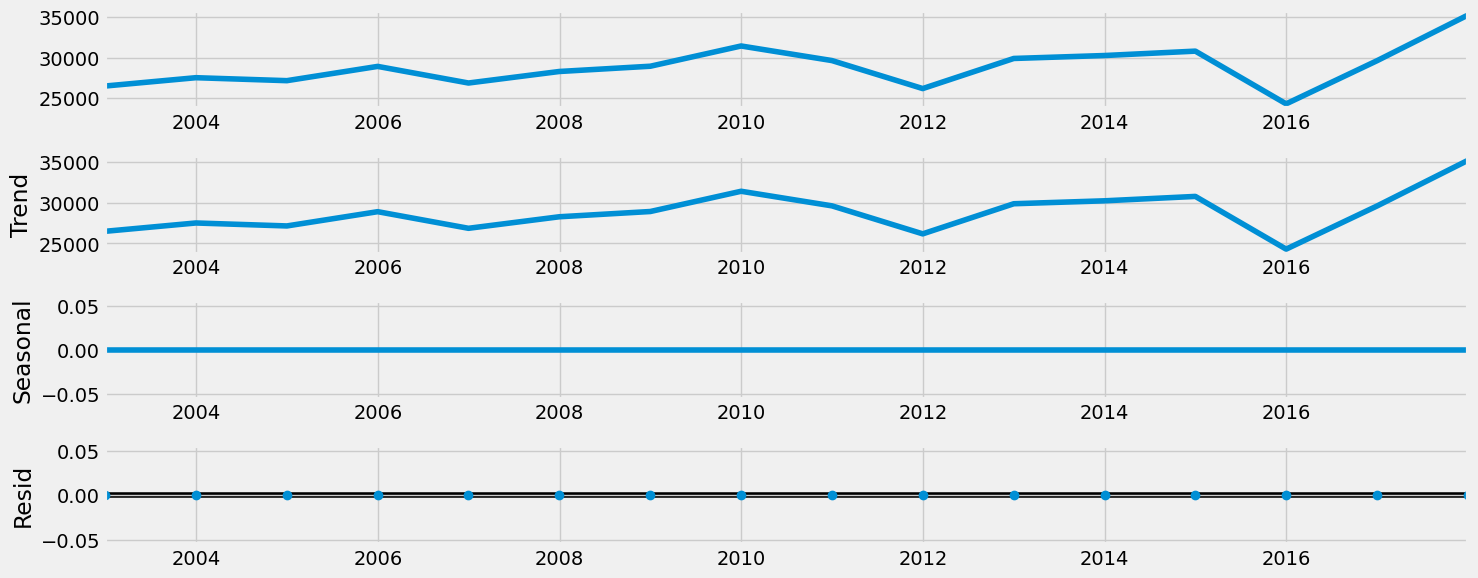

In [ ]:
# lets decomose series with year frequency
result_Y = seasonal_decompose(df[['PJME_MW']].asfreq('Y'), model='additive')
plt.rcParams["figure.figsize"] = 15, 6
result_Y.plot()
plt.show()

- very slow growing trend until 2016 year wiith 2 failure
- fast growing trend after 2016 year
- without seasonal and resid

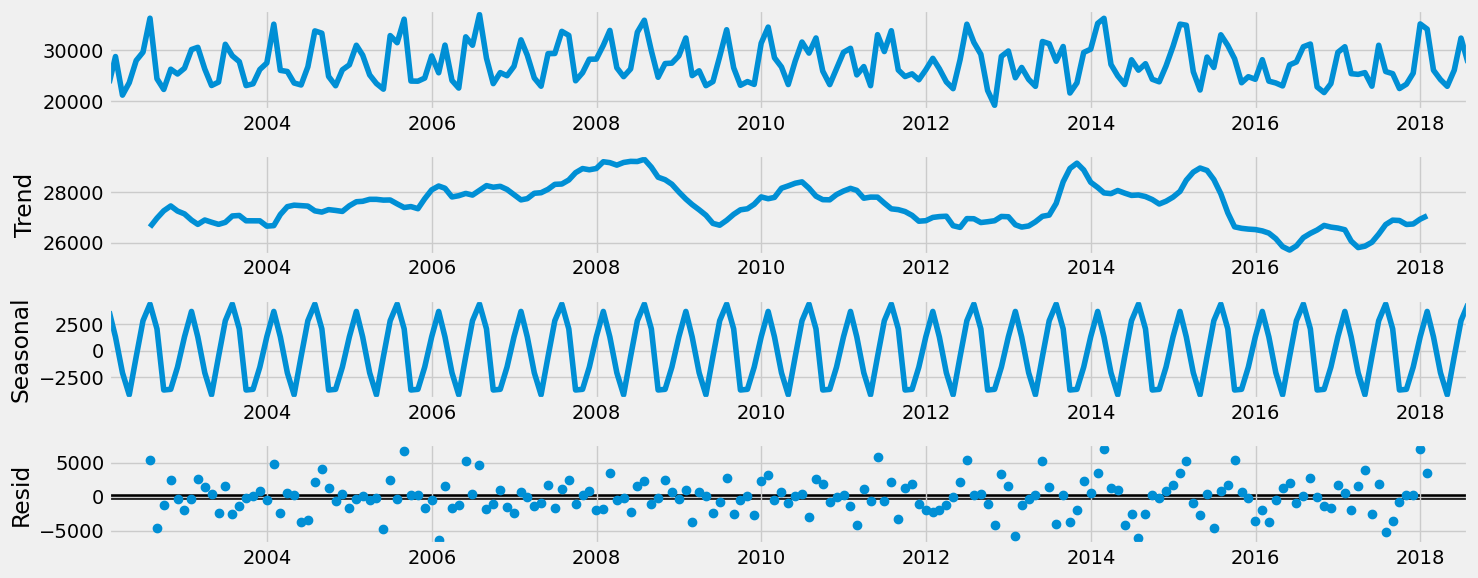

In [ ]:
# decomose series with month frequency
result_M = seasonal_decompose(df[['PJME_MW']].asfreq('M'), model='additive')
result_M.plot()
plt.show()

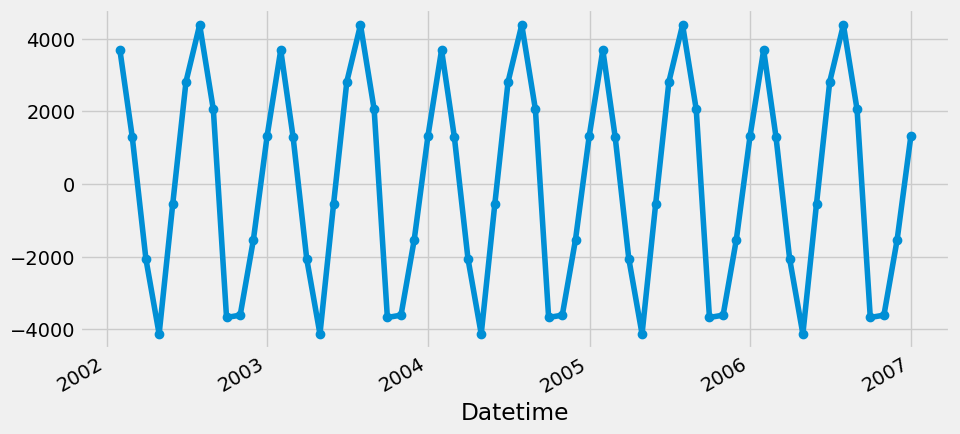

In [ ]:
# seaonal component by 60 lags
plt.rcParams["figure.figsize"] = 10, 5
result_M.seasonal[:60].plot(marker = "o")
plt.show()

- varios trend on different path of graph
- we have ciclical seasonal component with 12 lags and resid

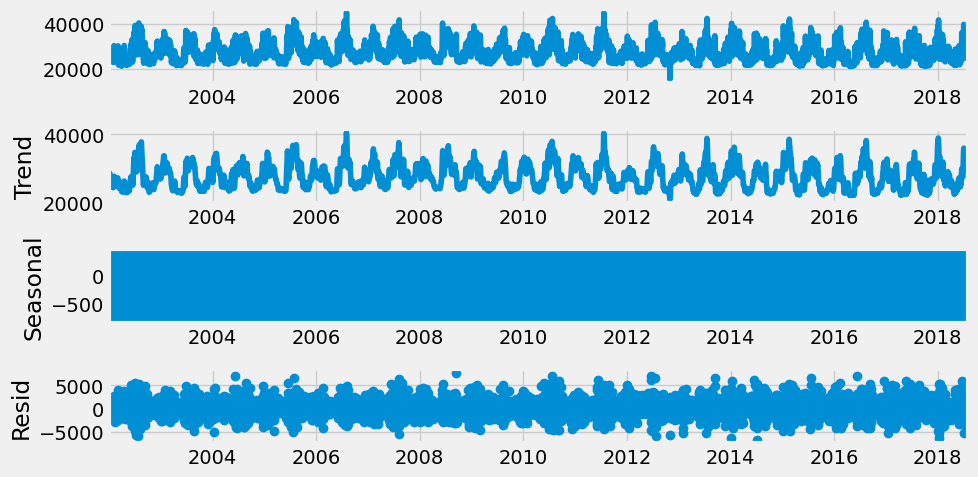

In [ ]:
# decomose series with daily frequency
result_D = seasonal_decompose(df[['PJME_MW']].asfreq('d'), model='additive')
result_D.plot()
plt.show()

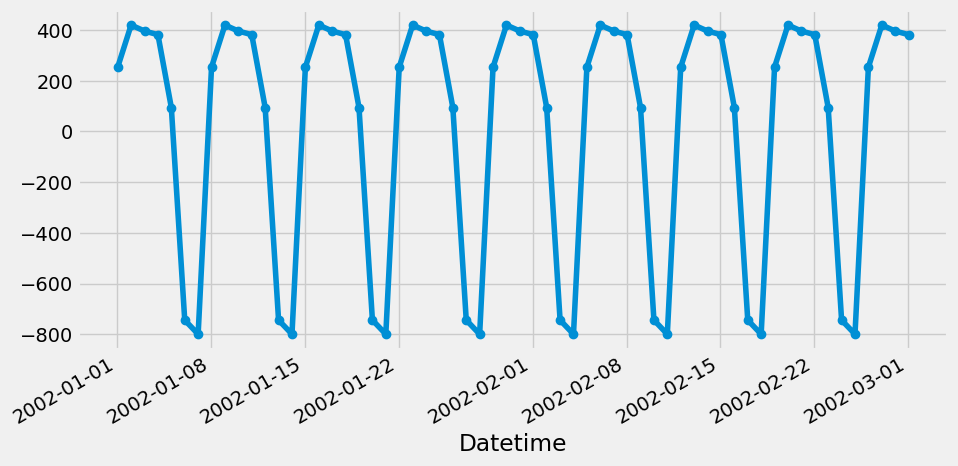

In [ ]:
# seaonal component by 60 lags
plt.rcParams["figure.figsize"] = 10, 5
result_D.seasonal[:60].plot(marker = "o")
plt.show()

- not seaching trend
- we have ciclical seasonal component with 7 lags and resid

#### some total:

- very slow growing global trend
- trend good seeing on month frequency
- expected to have seasonal component with cicles:
    - monthly (12 lags)
    - and daily (7 lags)
- different quarter cicles

## Prepearing model

Use downsampling becose we have big dataset

In [5]:
# Downsempling with month frequency
data_M = df.resample('M').sum()
data_M.head()

,PJME_MW
Datetime,
2002-01-31,23089022.0
2002-02-28,20320720.0
2002-03-31,21483191.0
2002-04-30,20516472.0
2002-05-31,20886798.0


### Train Split

In [6]:
# Split data on train and test( last 3 years)
cutoff = '2015-01-01'
train_df = data_M[['PJME_MW']].loc[:cutoff]
test_df = data_M[['PJME_MW']].loc[cutoff:]
train_df.shape, test_df.shape

((156, 1), (44, 1))

# Bilding Models & Machine Learning

On same ciclical gfaph we can't use simple mode like a linear regression
becose we will see only global trend.

Naive model for  same graph can be a Autoregression model and Moving Average.

Autoregression model can be used only for stationary row.
For this we need resech timeseries on stationary.
Plot autocorrelation and partial autocorrelation graph for this

In [7]:
# determine row stationarity
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('have unit roots, row is stationarity')
    else:
        print ("have't unit roots, row is't stationarity")

stat_test(train_df)

adf:  -2.1346861838032023
p-value:  0.23079771401347743
Critical values:  {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}
have unit roots, row is stationarity



The test statistics is less than all critical values, so we accept the null hypothesis ($H_0$).

Therefore, the values of US energy consumption after are stationary

Autocorrelation is the correlation of a series with itself (hence the prefix "auto"), but with a time shift. It helps you identify trends in your data and evaluate the impact of previously observed values ​​on your current observation.

Partial autocorrelation is used to determine the seasonal period. It is similar to classical autocorrelation, but additionally gets rid of the linear relationship between the shifted rows.

These plots show how the data correlates with a lagged version of itself.

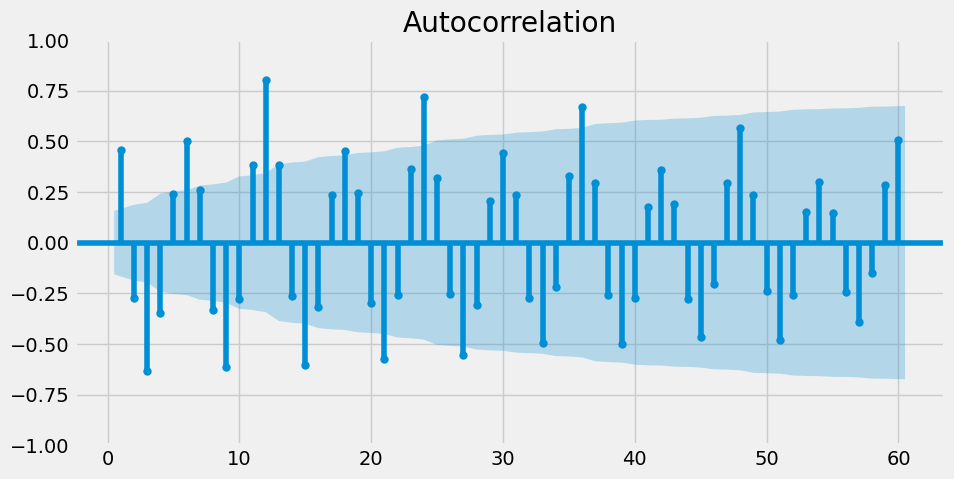

In [ ]:
# ACF
sgt.plot_acf(train_df, zero = False, lags = 60)
plt.rcParams["figure.figsize"] = 15, 5
plt.show()

We see a slowly fading wave autocorrelation with a period of 3

C:\IT\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


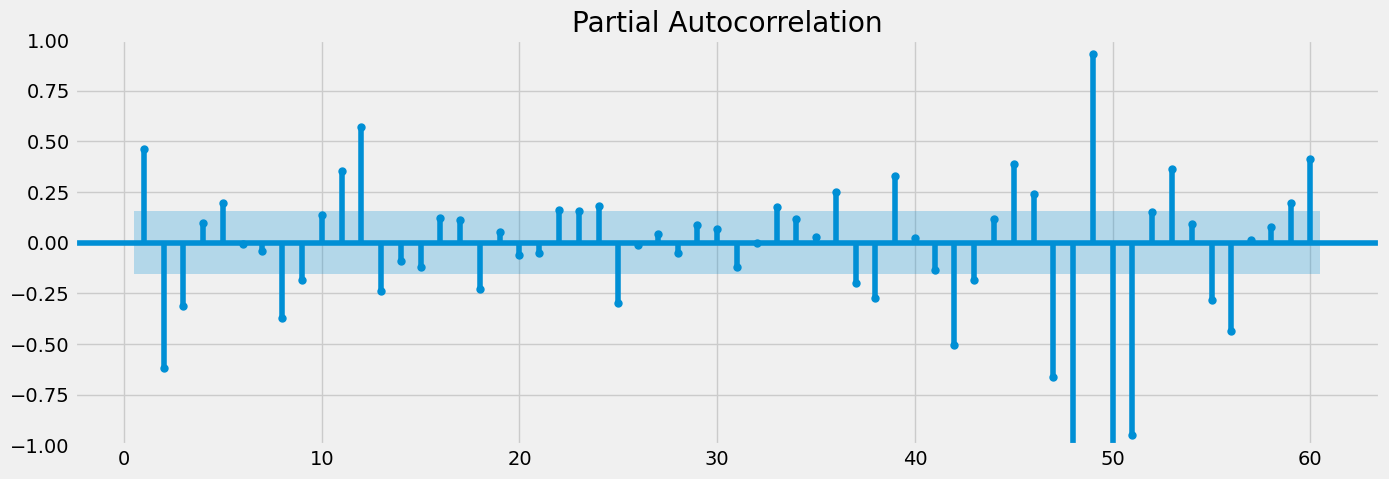

In [ ]:
# Построим график PACF(Часимчной автокорреляции)
sgt.plot_pacf(train_df, zero = False, lags = 60)
plt.show()

Interesting that around 50 lag we see a very high partial autocorrelation

Cyclicity and high values are traced

It's hard to choose $p$ from this plot 

### AR (Autoregression)

In [8]:
ar_model = AutoReg(train_df, lags=12).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                PJME_MW   No. Observations:                  156
Model:                    AutoReg(12)   Log Likelihood               -2219.618
Method:               Conditional MLE   S.D. of innovations        1196694.351
Date:                Thu, 20 Apr 2023   AIC                           4467.235
Time:                        20:08:24   BIC                           4508.813
Sample:                    01-31-2003   HQIC                          4484.130
                         - 12-31-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.716e+06   5.16e+06      1.688      0.091   -1.41e+06    1.88e+07
PJME_MW.L1      0.2325      0.068      3.397      0.001       0.098       0.367
PJME_MW.L2     -0.0769      0.070     -1.091    

In [25]:
mse_df = pd.DataFrame(columns = ["model", "mse", "AIC"])
mse_df

,model,mse,AIC


In [26]:
pred_ar = ar_model.predict(start=len(train_df), end=(len(data_M)-1), dynamic=False)

mse_df.loc[0] = ['AR', mean_squared_error(test_df, pred_ar), ar_model.aic]
mse_df

,model,mse,AIC
0,AR,1.545999e+13,4467.235496


In [39]:
pred_df = pd.DataFrame(index = data_M.index)
pred_df["ar_model_preds"] = pred_ar


pred_df["PJME_MW"] = data_M[["PJME_MW"]]

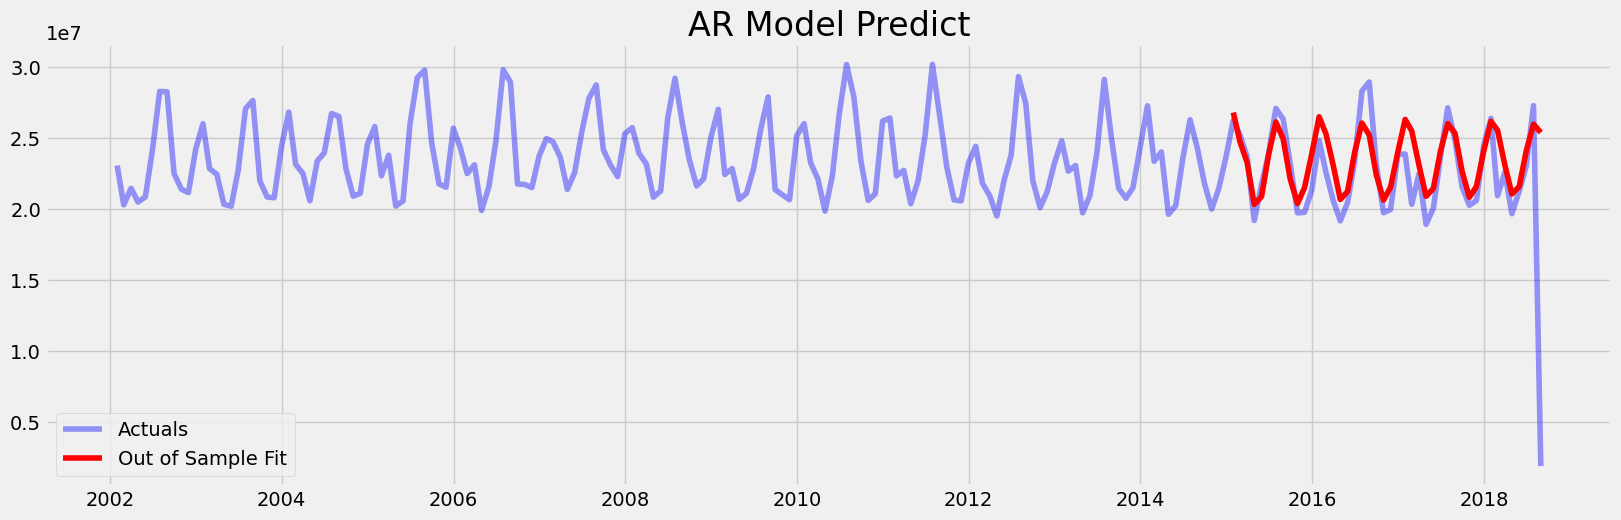

In [36]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["PJME_MW"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["ar_model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.title("AR Model Predict", size = 24)
plt.legend()

plt.show()

### MA (Moving Average)


The moving average model with window width = q is denoted as MA(q) and the prediction is plotted as the value of white noise at time t + moving average with a window of size q

The moving average is rarely used as a standalone model, but sometimes it helps to remove outliers and excess noise from the series to simplify visual analysis.

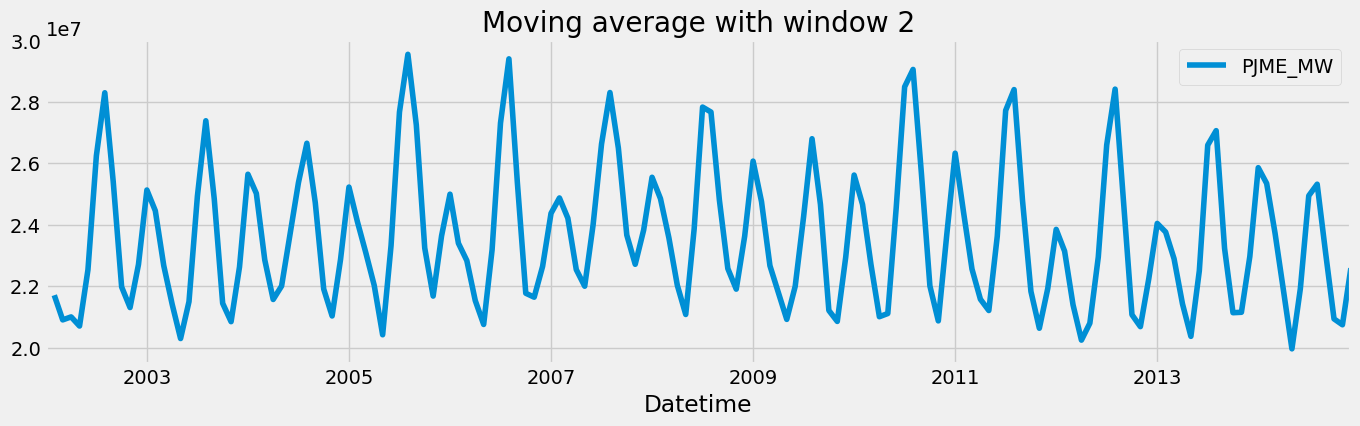

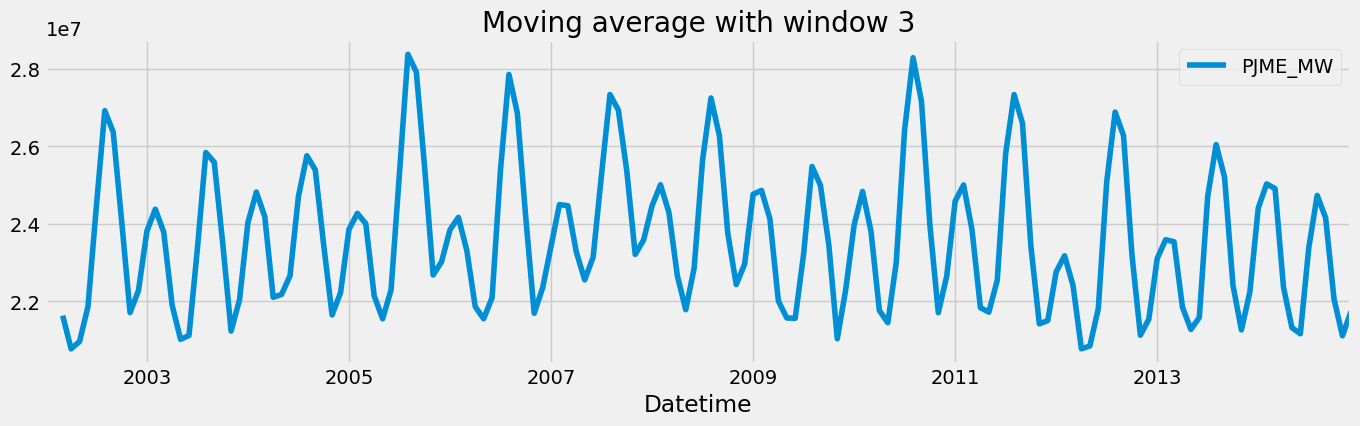

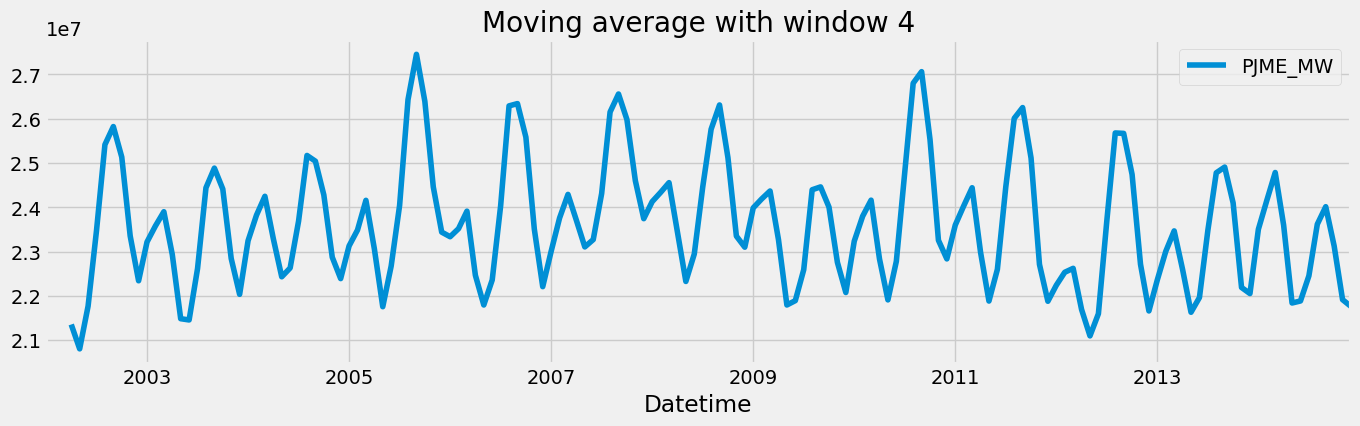

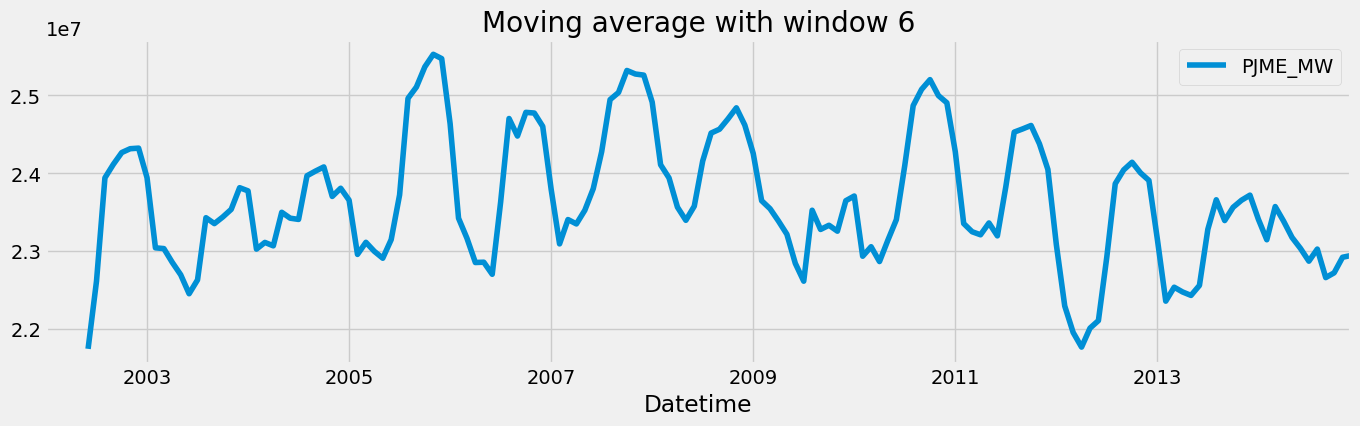

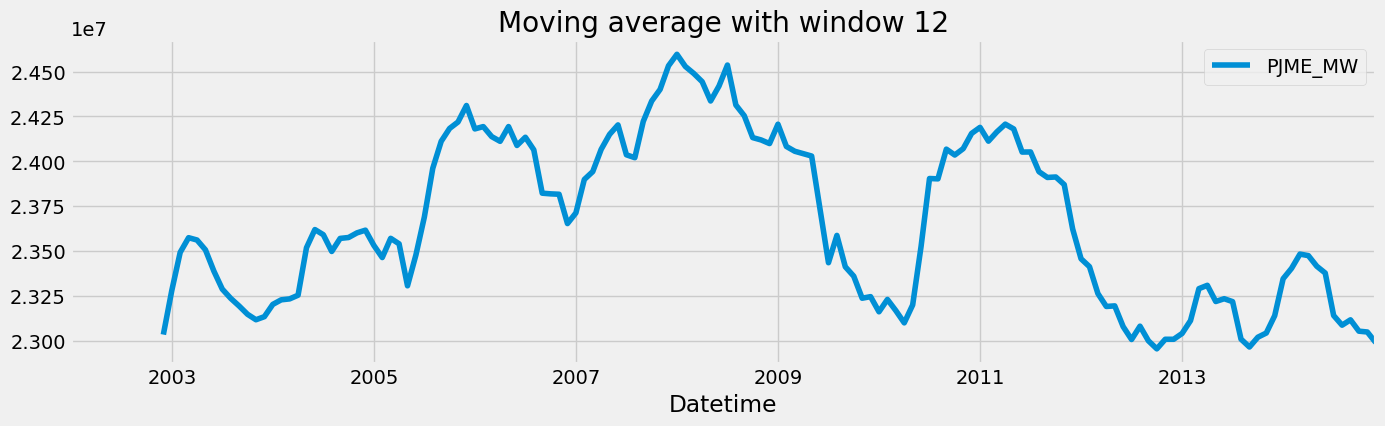

In [ ]:
# Plot MA graph with different window (q)
for p in [2,3,4,6,12]:
    train_df.rolling(window=p).mean().plot(figsize = (15,4), title = 'Moving average with window '+str(p))
    plt.show()

- graph МА with window lage then 3 lose information
- then optimal will be q=2 or q=3

### Model ARIMA.

The parameters p and q for ARMA/ARIMA are determined from the correlograms of the stationary series. That is, if our initial time series was not stationary, then correlograms are built for differences of the order that are stationary.


Now, using the Dickey-Fuller test, we will evaluate the stationarity of the time series and decide on the choice of the ARMA / ARIMA model.

Let's start building an ARIMA model with the following parameters:

- from MA model                       q =2  
- number of differentiation           d =0    
- from partial autocorrelation        р =12  

In [14]:
p = 12
d = 0
q =2

In [15]:
arima_model = ARIMA(train_df['PJME_MW'].dropna(), order = (p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\inetd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJME_MW   No. Observations:                  156
Model:                ARIMA(12, 0, 2)   Log Likelihood               -2409.000
Date:                Thu, 20 Apr 2023   AIC                           4850.000
Time:                        20:13:32   BIC                           4898.798
Sample:                    01-31-2002   HQIC                          4869.820
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.358e+07   2.56e+05     92.032      0.000    2.31e+07    2.41e+07
ar.L1          0.0792      0.110      0.717      0.474      -0.137       0.296
ar.L2         -0.0257      0.126     -0.204      0.838      -0.272       0.221
ar.L3         -0.0710      0.087     -0.820      0.412      -0.241       0.099
ar.L4         -0.0079      0.070     -0.113      0.910      -0.145       0.129
ar.L5         -0.0187      0.064     -0.292      0.770      -0.144       0.107
ar.L6         -0.0412      0.058     -0.712      0.476      -0.154       0.072
ar.L7          0.0664      0.067      0.998      0.318      -0.064       0.197
ar.L8         -0.0805      0.071     -1.134      0.257      -0.220       0.059
ar.L9         -0.1272      0.080     -1.599      0.110      -0.283       0.029
ar.L10        -0.0068      0.069     -0.098      0.922      -0.142       0.129
ar.L11         0.0633      0.068      0.927      0.354      -0.070       0.197
ar.L12         0.6424      0.071      9.058      0.000       0.503       0.781
ma.L1          0.2859      0.129      2.219      0.026       0.033       0.538
ma.L2          0.0395      0.133      0.298      0.766      -0.220       0.299
sigma2      1.426e+12      0.054   2.66e+13      0.000    1.43e+12    1.43e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.56
Prob(Q):                              0.97   Prob(JB):                         0.46
Heteroskedasticity (H):               0.71   Skew:                             0.23
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.33e+29. Standard errors may be unstable.
"""

The second column of section I contains some useful metrics that are used to compare different ARIMA models. In general, a model with a higher log-likelihood or a lower IC (AIC, BIC, or HQIC) is better, and vice versa.

If we consider the seasonal model (SARMA), then the following parameters can be added to the model.

m = 12 (data is likely to have yearly repeating patterns as seen in the visualization)

In [37]:
# check our forecast in dataframe
def input_forecast(model, model_fit):
    pred_df[model+"_preds"] = model_fit.predict(start = test_df.index[0], end = test_df.index[-1])

    forecast = model_fit.get_forecast(len(test_df.index))
    forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

    pred_df.at[test_df.index, model+"_preds_lower"] = forecast_df["lower PJME_MW"]
    pred_df.at[test_df.index, model+"_preds_upper"] = forecast_df["upper PJME_MW"]

In [40]:
input_forecast("arima_model", arima_model_fit)
pred_df

,ar_model_preds,PJME_MW,arima_model_preds,arima_model_preds_lower,arima_model_preds_upper
Datetime,,,,,
2002-01-31,NaN,23089022.0,NaN,NaN,NaN
2002-02-28,NaN,20320720.0,NaN,NaN,NaN
2002-03-31,NaN,21483191.0,NaN,NaN,NaN
2002-04-30,NaN,20516472.0,NaN,NaN,NaN
2002-05-31,NaN,20886798.0,NaN,NaN,NaN
...,...,...,...,...,...
2018-04-30,2.108595e+07,19694352.0,2.114066e+07,1.744283e+07,2.483849e+07
2018-05-31,2.160074e+07,21278364.0,2.181347e+07,1.810735e+07,2.551960e+07
2018-06-30,2.410914e+07,23050418.0,2.417458e+07,2.046828e+07,2.788087e+07


In [42]:
# define plot function for forecast
def plot_forecast(model):
    plt.rcParams["figure.figsize"] = 18, 12

    plt.subplot(2, 1, 1)
    plt.plot(pred_df["PJME_MW"], color = "blue", label = "Actuals", alpha = 0.4)
    plt.plot(pred_df.loc[test_df.index][model+"_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
    plt.plot(pred_df.loc[test_df.index][model+"_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
    plt.plot(pred_df.loc[test_df.index][model+"_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
    plt.title("Full "+model+" Fit", size = 24)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(pred_df.loc[test_df.index]["PJME_MW"], color = "blue", label = "Actuals", alpha = 0.6)
    plt.plot(pred_df.loc[test_df.index][model+"_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
    plt.plot(pred_df.loc[test_df.index][model+"_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
    plt.plot(pred_df.loc[test_df.index][model+"_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
    plt.title("Out of "+model+" Sample Fit", size = 24)
    plt.legend()

    return plt.show()

In [55]:
mse_df.loc[1] = ['ARIMA', mean_squared_error(test_df, pred_df["arima_model_preds"].loc[test_df.index[0]:].values), arima_model_fit.aic]
mse_df

,model,mse,AIC
0,AR,1.545999e+13,4467.235496
1,ARIMA,1.514785e+13,4850.000100


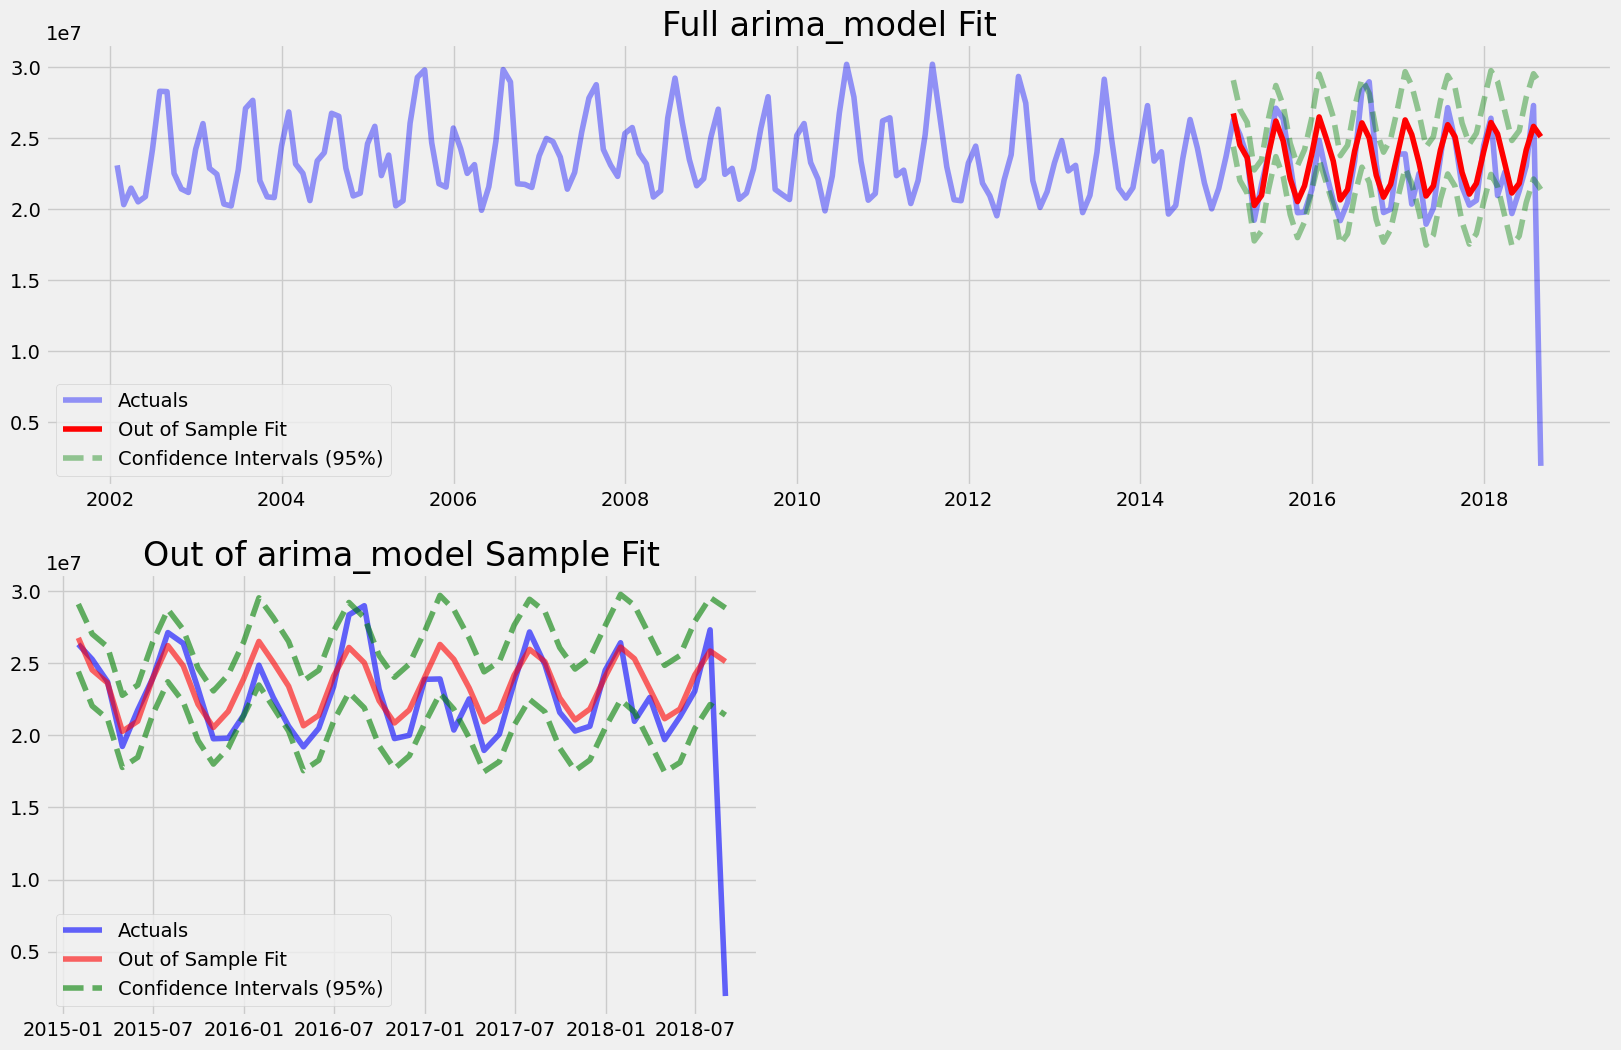

In [44]:
plot_forecast("arima_model")

### Model SARIMAX

ARIMA with seasonal component

In [45]:
# trian fit model
seas_model = SARIMAX(train_df["PJME_MW"].dropna(), order = (p, d, q))
seas_model_fit = seas_model.fit(verbose = True)
seas_model_fit.summary()

c:\Users\inetd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
c:\Users\inetd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJME_MW   No. Observations:                  156
Model:              SARIMAX(12, 0, 2)   Log Likelihood               -2414.755
Date:                Fri, 21 Apr 2023   AIC                           4859.510
Time:                        10:11:51   BIC                           4905.258
Sample:                    01-31-2002   HQIC                          4878.091
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1161      0.100      1.161      0.246      -0.080       0.312
ar.L2          0.0356      0.131      0.271      0.786      -0.221       0.293
ar.L3         -0.0299      0.086     -0.350      0.727      -0.198       0.138
ar.L4          0.0292      0.060      0.490      0.624      -0.088       0.146
ar.L5          0.0295      0.057      0.513      0.608      -0.083       0.142
ar.L6          0.0054      0.054      0.101      0.920      -0.100       0.111
ar.L7          0.1072      0.065      1.639      0.101      -0.021       0.235
ar.L8         -0.0457      0.065     -0.701      0.484      -0.173       0.082
ar.L9         -0.0861      0.081     -1.064      0.288      -0.245       0.073
ar.L10         0.0395      0.058      0.680      0.497      -0.074       0.153
ar.L11         0.1064      0.062      1.708      0.088      -0.016       0.228
ar.L12         0.6924      0.072      9.641      0.000       0.552       0.833
ma.L1          0.2814      0.123      2.288      0.022       0.040       0.523
ma.L2          0.0154      0.126      0.122      0.903      -0.232       0.263
sigma2      1.448e+12   5.06e-14   2.86e+25      0.000    1.45e+12    1.45e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.12
Prob(Q):                              0.91   Prob(JB):                         0.57
Heteroskedasticity (H):               0.68   Skew:                             0.21
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.25e+42. Standard errors may be unstable.
"""

In [57]:
input_forecast('seas_model', seas_model_fit)

In [59]:
mse_df.loc[2] = ['SARIMAX', mean_squared_error(test_df, pred_df["seas_model_preds"].loc[test_df.index[0]:].values), seas_model_fit.aic]
mse_df

,model,mse,AIC
0,AR,1.545999e+13,4467.235496
1,ARIMA,1.514785e+13,4850.000100
2,SARIMAX,1.405257e+13,4859.509821


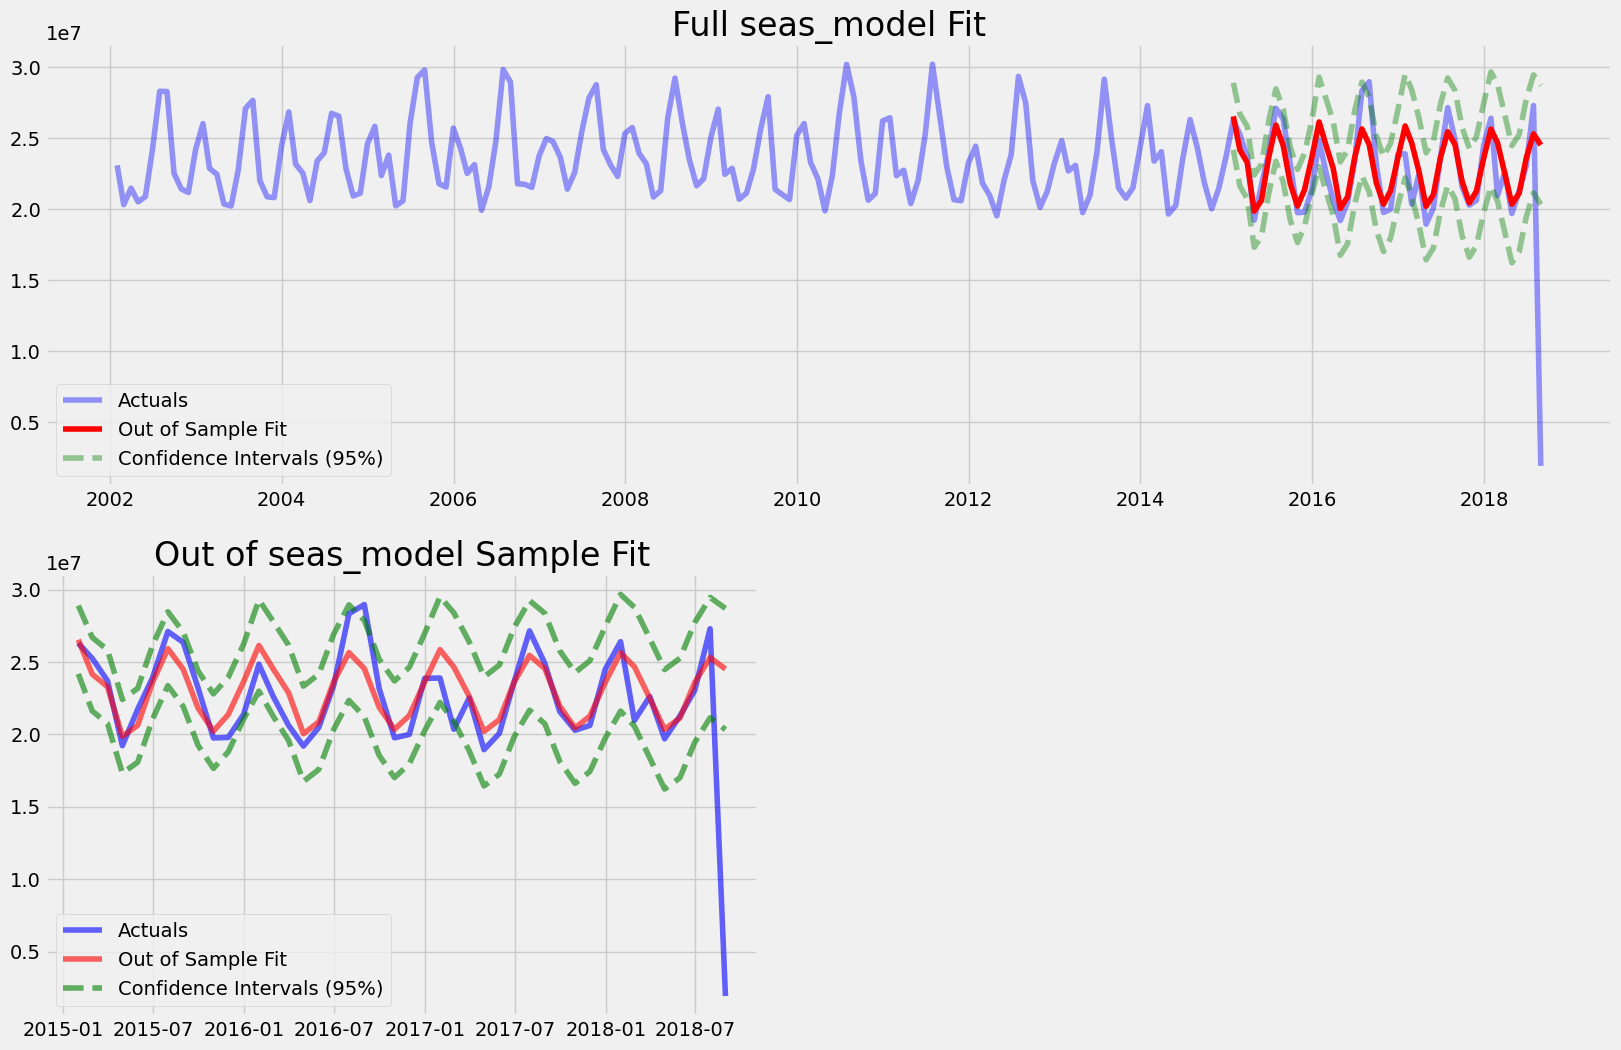

In [60]:
plot_forecast('seas_model')

In [61]:
mse_df.to_csv("metric_df")

### Hyperparameter Tuning with Pmdarima

In [ ]:
import pmdarima as pm

smodel = pm.auto_arima(train_df, start_q=2,
                       max_p=13, max_d=2, 
                       max_q=12, start_P=1,
                       start_Q=1, max_P=2, 
                       max_D=1, max_Q=2, 
                       m=12,seasonal=True,
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True, verbose = True
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5061.943, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4964.068, Time=1.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4938.076, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5743.167, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=5004.680, Time=0.05 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=4939.750, Time=0.85 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=4922.574, Time=0.28 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=4924.449, Time=1.66 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=4983.797, Time=0.25 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=4920.557, Time=0.41 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=4936.222, Time=0.24 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=4909.764, Time=2.04 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=4914.228, Time=1.12 sec
 ARIMA(1,0,1)(2,0,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood               -2444.593
Date:                            Mon, 20 Mar 2023   AIC                           4903.186
Time:                                    18:46:52   BIC                           4924.535
Sample:                                01-31-2002   HQIC                          4911.857
                                     - 12-31-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.805e+07   8.38e-08   2.15e+14      0.000    1.81e+07    1.81e+07
ar.L1         -0.7701      0.299     -2.578      0.010      -1.356      -0.185
ma.L1          0.9011      0.188      4.801      0.000       0.533       1.269
ar.S.L12       0.0436      0.433      0.101      0.920      -0.805       0.893
ar.S.L24       0.5228      0.412      1.269      0.204      -0.285       1.330
ma.S.L12       0.6195      0.501      1.236      0.217      -0.363       1.602
sigma2      3.696e+12   2.35e-14   1.57e+26      0.000     3.7e+12     3.7e+12
===================================================================================
Ljung-Box (L1) (Q):                  12.89   Jarque-Bera (JB):                10.39
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.61   Skew:                             0.62
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.93e+43. Standard errors may be unstable.
"""

In [62]:
# Best pmdarima model:  ARIMA(1,0,1)(2,0,1)[12]
seas_model_pmd = SARIMAX(train_df["PJME_MW"].dropna(), order = (1, 0, 1), seasonal_order = (2,0,1,12))
seas_model_pmd_fit = seas_model_pmd.fit(verbose = True)
seas_model_pmd_fit.summary()

c:\Users\inetd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            PJME_MW   No. Observations:                  156
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood               -2478.999
Date:                            Fri, 21 Apr 2023   AIC                           4969.998
Time:                                    10:58:42   BIC                           4988.297
Sample:                                01-31-2002   HQIC                          4977.430
                                     - 12-31-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9824      0.066     14.877      0.000       0.853       1.112
ma.L1         -0.5998      0.297     -2.017      0.044      -1.182      -0.017
ar.S.L12       0.9987      0.866      1.153      0.249      -0.699       2.697
ar.S.L24      -0.0407      0.748     -0.054      0.957      -1.507       1.426
ma.S.L12      -0.6337      0.847     -0.749      0.454      -2.293       1.026
sigma2      7.267e+12   5.05e-14   1.44e+26      0.000    7.27e+12    7.27e+12
===================================================================================
Ljung-Box (L1) (Q):                   3.53   Jarque-Bera (JB):                 5.05
Prob(Q):                              0.06   Prob(JB):                         0.08
Heteroskedasticity (H):               0.51   Skew:                             0.44
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.73e+42. Standard errors may be unstable.
"""

In [63]:
input_forecast('seas_model_pmd', seas_model_pmd_fit)

In [64]:
mse_df.loc[3] = ['SARIMAX with pmd', mean_squared_error(test_df, pred_df["seas_model_pmd_preds"].loc[test_df.index[0]:].values), seas_model_pmd_fit.aic]
mse_df

,model,mse,AIC
0,AR,1.545999e+13,4467.235496
1,ARIMA,1.514785e+13,4850.000100
2,SARIMAX,1.405257e+13,4859.509821
3,SARIMAX with pmd,1.257913e+13,4969.997830


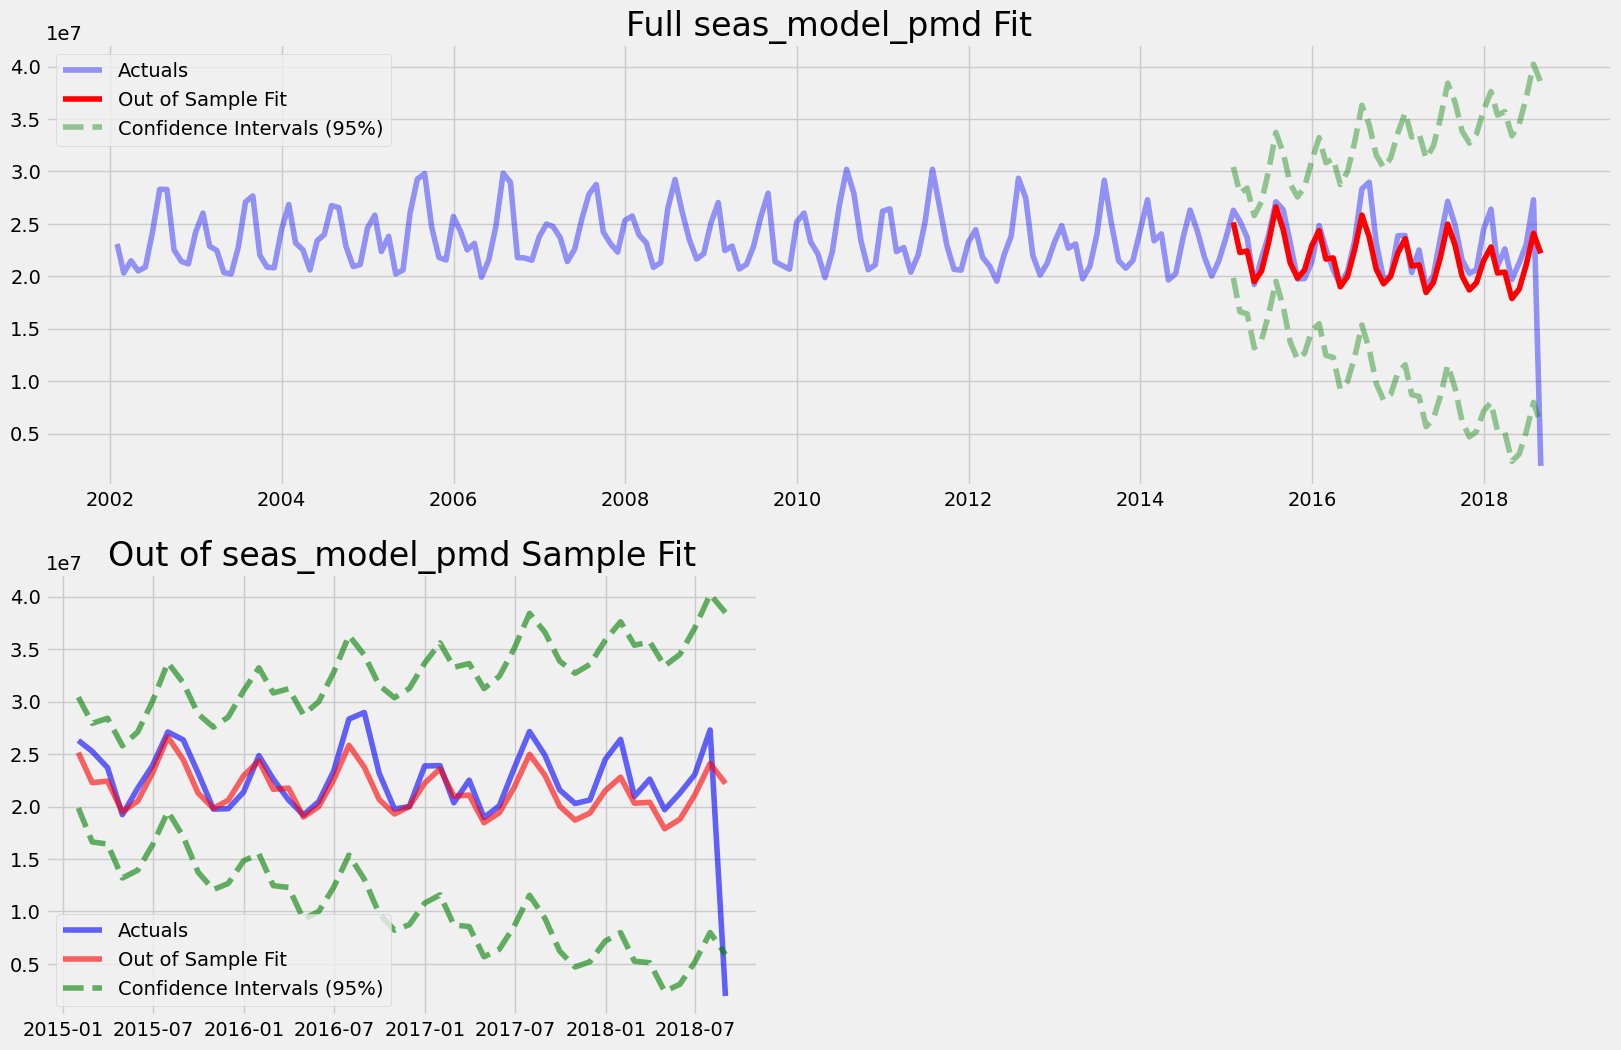

In [65]:
plot_forecast('seas_model_pmd')

In [116]:
# pred_df = pd.read_csv('pred_df')
# pred_df = pred_df.set_index('Datetime')
# pred_df.index = pd.to_datetime(pred_df.index)
# pred_df

#### Prophet

In [67]:
train_df_pr = pd.DataFrame(data = {'ds':train_df.index,'y': train_df["PJME_MW"]})
train_df_pr.index = np.arange(len(train_df))

In [68]:
pred_df_pr = pd.DataFrame({'ds':test_df.index} )
pred_df_pr.head(5)

,ds
0,2015-01-31
1,2015-02-28
2,2015-03-31
3,2015-04-30
4,2015-05-31


In [69]:
pr_model = Prophet()
pr_model_fit = pr_model.fit(train_df_pr)

11:04:31 - cmdstanpy - INFO - Chain [1] start processing
11:04:31 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
forecast_df = pr_model_fit.predict(pred_df_pr)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
39,2018-04-30,1.900858e+07,1.785851e+07,2.016739e+07
40,2018-05-31,2.006032e+07,1.879313e+07,2.128941e+07
41,2018-06-30,2.322105e+07,2.209106e+07,2.451132e+07
42,2018-07-31,2.703565e+07,2.580562e+07,2.829410e+07
43,2018-08-31,2.605375e+07,2.473784e+07,2.722325e+07


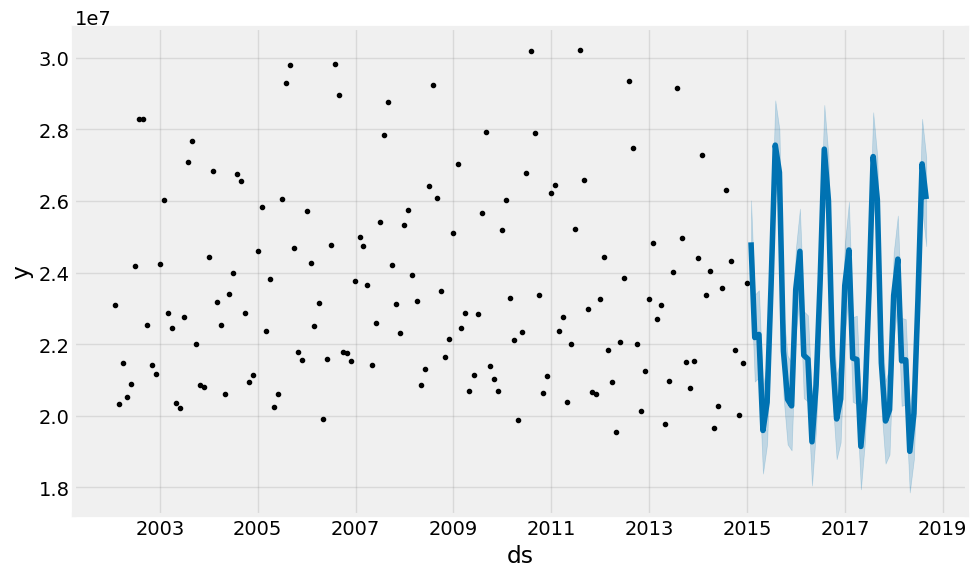

In [72]:
fig = pr_model.plot(forecast_df)

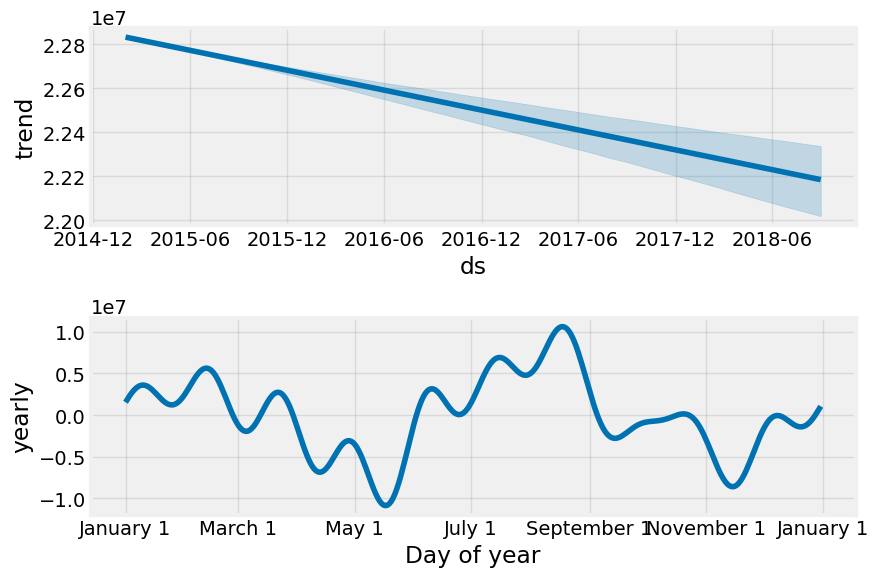

In [73]:
fig = pr_model.plot_components(forecast_df)

In [74]:
forecast_df = forecast_df.set_index('ds')
forecast_df.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2015-01-31,2.283141e+07,2.361262e+07,2.601580e+07,2.283141e+07,2.283141e+07,2.013295e+06,2.013295e+06,2.013295e+06,2.013295e+06,2.013295e+06,2.013295e+06,0.0,0.0,0.0,2.484471e+07
2015-02-28,2.281755e+07,2.095566e+07,2.338220e+07,2.281690e+07,2.281775e+07,-6.317145e+05,-6.317145e+05,-6.317145e+05,-6.317145e+05,-6.317145e+05,-6.317145e+05,0.0,0.0,0.0,2.218584e+07
2015-03-31,2.280221e+07,2.107405e+07,2.350661e+07,2.280049e+07,2.280330e+07,-5.295987e+05,-5.295987e+05,-5.295987e+05,-5.295987e+05,-5.295987e+05,-5.295987e+05,0.0,0.0,0.0,2.227261e+07
2015-04-30,2.278736e+07,1.838601e+07,2.078920e+07,2.278427e+07,2.278957e+07,-3.196737e+06,-3.196737e+06,-3.196737e+06,-3.196737e+06,-3.196737e+06,-3.196737e+06,0.0,0.0,0.0,1.959062e+07
2015-05-31,2.277201e+07,1.920432e+07,2.155168e+07,2.276671e+07,2.277566e+07,-2.396508e+06,-2.396508e+06,-2.396508e+06,-2.396508e+06,-2.396508e+06,-2.396508e+06,0.0,0.0,0.0,2.037550e+07


In [97]:
pred_df["prophet_model_preds"] = pd.Series(dtype=float)
pred_df["prophet_model_preds_lower"] = pd.Series()
pred_df["prophet_model_preds_upper"] = pd.Series()

In [104]:
pred_df.loc[test_df.index]["prophet_model_preds"] = forecast_df["yhat"]
pred_df.loc[test_df.index]["prophet_model_preds_lower"] = forecast_df["yhat_lower"]
pred_df.loc[test_df.index]["prophet_model_preds_upper"] = forecast_df["yhat_upper"]

In [108]:
from prophet.diagnostics import cross_validation

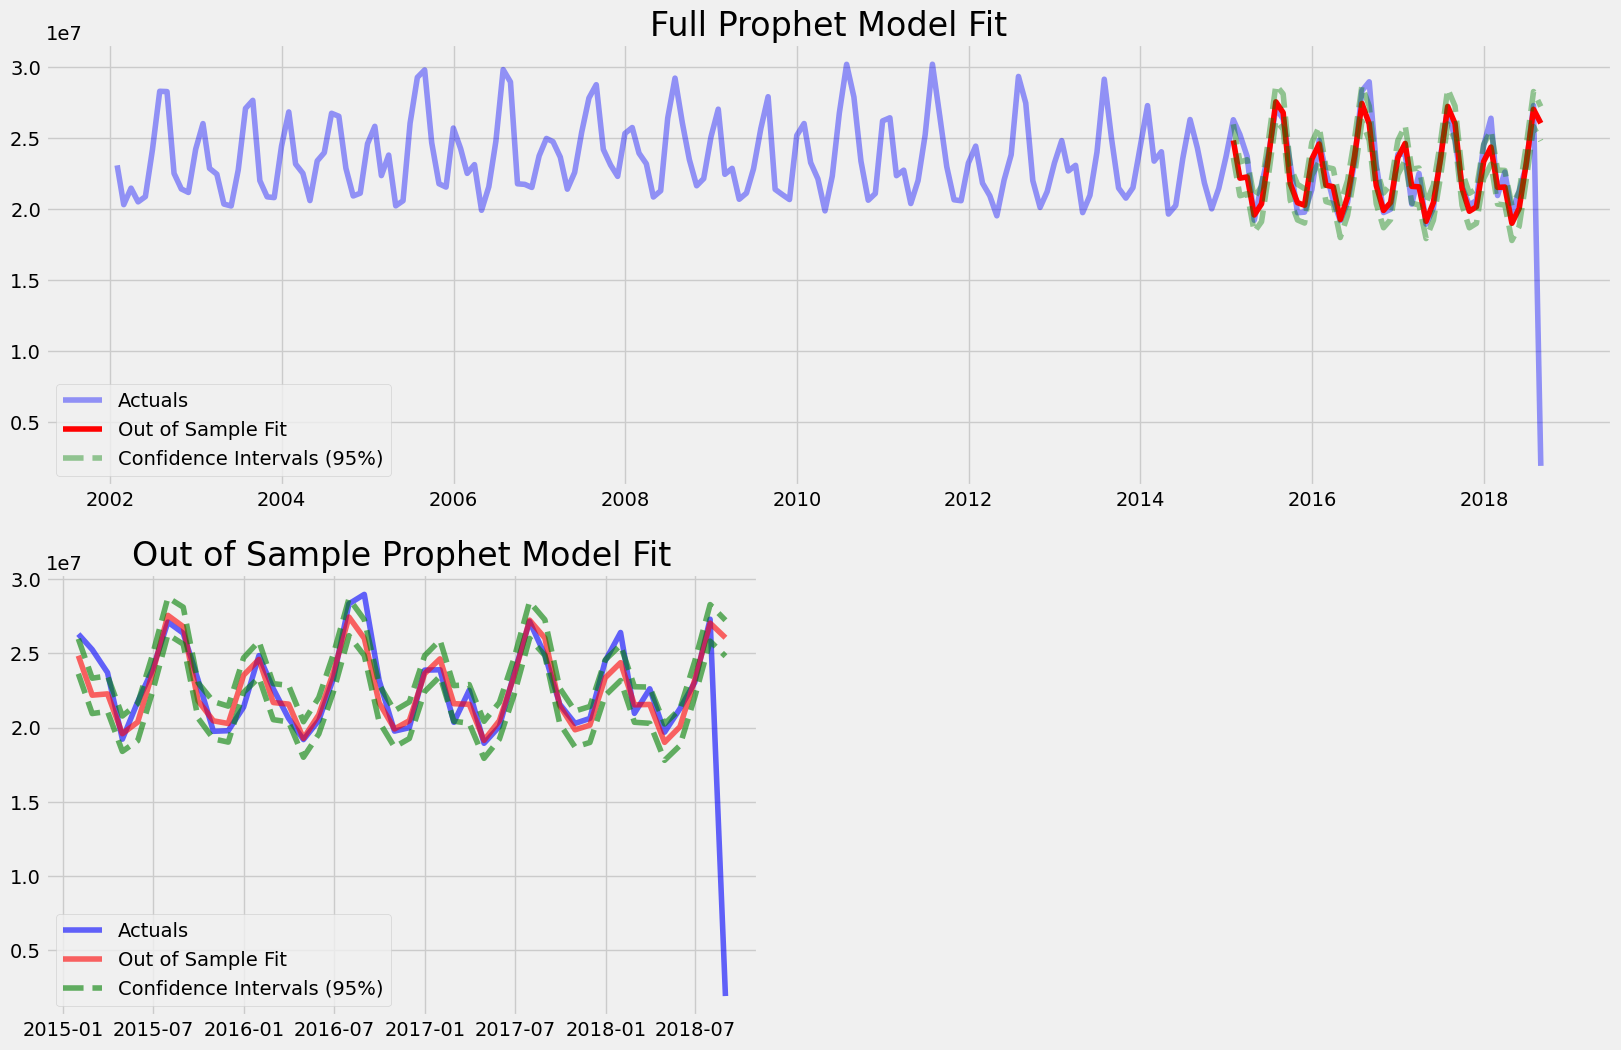

In [127]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["PJME_MW"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(forecast_df.loc[test_df.index]["yhat"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(forecast_df.loc[test_df.index]["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(forecast_df.loc[test_df.index]["yhat_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Prophet Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["PJME_MW"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(forecast_df.loc[test_df.index]["yhat"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(forecast_df.loc[test_df.index]["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(forecast_df.loc[test_df.index]["yhat_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Prophet Model Fit", size = 24)
plt.legend()

plt.show()

In [120]:
mse_df.loc[4] = ['Prophet', mean_squared_error(test_df, forecast_df["yhat"].values), 'nan']
mse_df

,model,mse,AIC
0,AR,1.545999e+13,4467.235496
1,ARIMA,1.514785e+13,4850.0001
2,SARIMAX,1.405257e+13,4859.509821
3,SARIMAX with pmd,1.257913e+13,4969.99783
4,Prophet,1.439926e+13,nan


### Conclusion

- ar model fits the data well, but predicts the lowest cost
- the arima model gives a better forecast than the ar model
- the sarimax model has a more accurate prediction compared to larger values, but the scatter is
- the prophet model is based on graphs and gives a fairly high accuracy and has the smallest spread

In [127]:
pred_df.to_csv('pred_df')
mse_df.to_csv('metric_df')